In [256]:
import viabill
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from category_encoders import WOEEncoder
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

import lightgbm as lgb

from viabill.pipelines.model import DecisionTreeDiscretizer_DF as DecisionTreeDiscretizer_DF

# Load data 


In [4]:
catalog.list()

df_oot = catalog.load('df_oot')
df_train = catalog.load('df_train')
df_test = catalog.load('df_test')
df_valid = catalog.load('df_valid')

2021-04-19 21:01:27,636 - kedro.io.data_catalog - INFO - Loading data from `df_oot` (ParquetDataSet)...
2021-04-19 21:01:27,909 - kedro.io.data_catalog - INFO - Loading data from `df_train` (ParquetDataSet)...
2021-04-19 21:01:29,206 - kedro.io.data_catalog - INFO - Loading data from `df_test` (ParquetDataSet)...
2021-04-19 21:01:29,502 - kedro.io.data_catalog - INFO - Loading data from `df_valid` (ParquetDataSet)...


```
df_oot   - data set that will allow to check model performance on the
           latest available data (out of time) (EXISTING CUSTOMER),
df_train - dataset for model training (EXISTING CUSTOMER),
df_test  - dataset for model performance assessing (out of sample) (EXISTING CUSTOMER),
df_valid - dataset for hp tuning (out of sample) (EXISTING CUSTOMER),
```

# Prepare data for training

In [12]:
print("Nulls percentage:")
(df_train.replace('',np.nan).isna().sum()/ df_train.shape[0]).map(lambda x:'{:.2f}%'.format(x*100)).sort_values(ascending=False).head(10)

Nulls percentage:


postalAddress                    2.01%
postalAddress_clean              2.01%
income                           1.99%
customerID                       0.00%
money_lost_lst_06_sum            0.00%
late_payment_first_lst_06_avg    0.00%
price_lst_06_avg                 0.00%
late_lst_06_avg                  0.00%
money_lost_lst_06_avg            0.00%
defualted_payment_lst_06_avg     0.00%
dtype: object

fill na in income - special value -999

In [15]:
df_train.fillna({'income':-999}, inplace=True)
df_test.fillna({'income':-999}, inplace=True)
df_valid.fillna({'income':-999}, inplace=True)
df_oot.fillna({'income':-999}, inplace=True)

# Logistic regression

In [297]:
# 'residentialAddress_clean','shopID' - exclude from model because causing overfit and breach staistical assumption


In [298]:
categorical_cols = ['sex', 
                    'geo_risk_rank', 
                    'same_address']
numerical_cols = ['age', 'income', 'price'] + \
    df_train.filter(regex='(^hist_)|(_lst_)').columns.to_list()

target_def = 'default'
target_late = 'late'

In [299]:
pipe = make_pipeline(
    ColumnTransformer([
        ('num', DecisionTreeDiscretizer_DF(max_depth = 3, min_samples_prc_leaf=0.05), numerical_cols),
        ('cat', 'passthrough', categorical_cols),
    ]),
    WOEEncoder(random_state=1),
    )

In [300]:
sample = df_train.sample(10000, random_state=1).reset_index(drop=True)

In [301]:
df_train_transfored = pipe.fit_transform(df_train, df_train[target_def])

In [302]:
df_test_transfored = pipe.transform(df_test)

In [303]:
sample_transformed = pipe.transform(sample)

In [304]:
# no regularization
model_LR_sfs = LogisticRegression(random_state=1, C=10e6, penalty='l2', max_iter=1000)


In [305]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(model_LR_sfs, 
           k_features=15, 
           forward=True, 
           floating=False, 
           verbose=False,
           scoring='roc_auc',
           cv=3)

sfs1 = sfs1.fit(sample_transformed, sample[target_def])


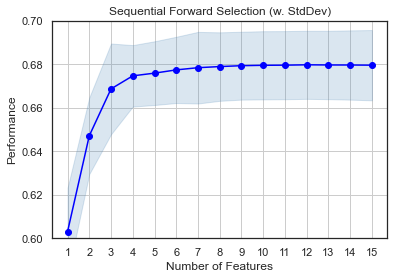

In [315]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt


fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim([0.6, 0.7])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [316]:
nbr=8
sfs1.get_metric_dict()[nbr]

{'feature_idx': (0, 6, 36, 38, 40, 44, 70, 72),
 'cv_scores': array([0.67900816, 0.69825479, 0.65966616]),
 'avg_score': 0.6789763687119468,
 'feature_names': (0, 6, 36, 38, 40, 44, 70, 72),
 'ci_bound': 0.035451140414454387,
 'std_dev': 0.015753756313961163,
 'std_err': 0.01113958791876233}

In [318]:
columns_transformed = pipe.named_steps['columntransformer'].get_feature_names()
feature_idx = list(sfs1.get_metric_dict()[nbr]['feature_idx'])
best_features_default = list(np.array(columns_transformed)[feature_idx])
best_features_default = [i.replace('num__','').replace('cat__','') for i in best_features_default]

In [319]:
best_features_default

['age',
 'hist_late_sum',
 'money_lost_lst_06_sum',
 'price_lst_06_sum',
 'default_lst_06_avg',
 'price_lst_06_avg',
 'sex',
 'same_address']

<AxesSubplot:>

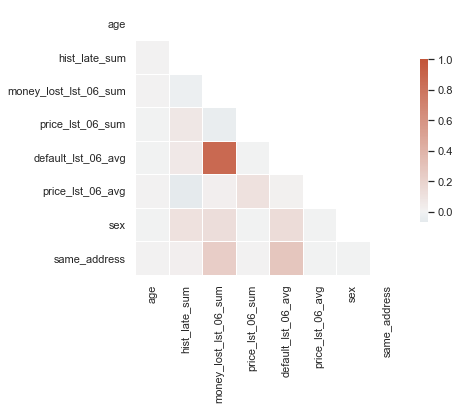

In [320]:
import seaborn as sns
sns.set_theme(style="white")

_tmp = df_train_transfored.iloc[:,feature_idx]
_tmp.columns=best_features_default

corr=_tmp.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [321]:
model_LR = LogisticRegression(random_state=1, C=10e6, penalty='l2', max_iter=300)
model_LR.fit(df_train_transfored.iloc[:,feature_idx], df_train[target_def])

LogisticRegression(C=10000000.0, max_iter=300, random_state=1)

Train AUC= 0.666
Test AUC= 0.663


<function matplotlib.pyplot.show(close=None, block=None)>

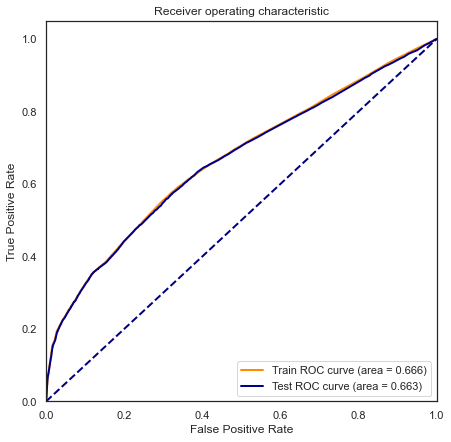

In [322]:
%matplotlib inline

y_pred_train = model_LR.predict_proba(df_train_transfored.iloc[:,feature_idx])[:,1]
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(df_train[target_def], y_pred_train, pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
print("Train AUC= %.3f"% roc_auc_train)

y_pred_test = model_LR.predict_proba(df_test_transfored.iloc[:,feature_idx])[:,1]
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(df_test[target_def], y_pred_test, pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
print("Test AUC= %.3f"% roc_auc_test)  

fig, ax = plt.subplots(figsize=(7,7))
lw = 2
ax.plot(fpr_train, tpr_train,  color='darkorange',
         lw=lw, label='Train ROC curve (area = %0.3f)' % roc_auc_train)
ax.plot(fpr_test, tpr_test,  color='darkblue',
         lw=lw, label='Test ROC curve (area = %0.3f)' % roc_auc_test)
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show

In [323]:
import pandas as pd 
  
# building the model and fitting the data
X = df_train_transfored.iloc[:,feature_idx]
X = sm.add_constant(X)
y = df_train[target_def]
log_reg = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.281517
         Iterations 7


In [324]:
print(log_reg.summary(xname=['const']+best_features_default))

                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:               316942
Model:                          Logit   Df Residuals:                   316933
Method:                           MLE   Df Model:                            8
Date:                Mon, 19 Apr 2021   Pseudo R-squ.:                 0.07596
Time:                        22:54:34   Log-Likelihood:                -89225.
converged:                       True   LL-Null:                       -96559.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.2986      0.007   -352.021      0.000      -2.311      -2.286
age                       0.8605      0.422      2.038      0.042       0.033       1.688
hist_lat

Caution:
* coef for `const` is negative,    
* confidence interval for `price_lst_06_avg` is crossin 0 value and has high p-value which mean that probably sguld be removed or changed for some other variable, 
* money_lost_lst_06_sum and default_lst_06_avg is correlated at 0.86 - too much,

# LightGBM + HyperOpt

In [341]:
import category_encoders as ce
import lightgbm as lgb
from sklearn.metrics import roc_auc_score


In [330]:
params = catalog.load('model_lgb_params')
parameters = catalog.load('params:hp_params')


2021-04-19 22:58:30,809 - kedro.io.data_catalog - INFO - Loading data from `model_lgb_params` (MlflowJSONDataSet)...
2021-04-19 22:58:30,816 - kedro.io.data_catalog - INFO - Loading data from `params:hp_params` (MemoryDataSet)...


In [332]:
categorical_cols = ['sex', 'residentialAddress_clean',
                    'postalAddress_clean', 'geo_risk_rank', 'shopID',
                    'same_address']
numerical_cols = ['age', 'income', 'price'] + \
    df_train.filter(regex='(^hist_)|(_lst_)').columns.to_list()
target_column = ['default']

transformer = make_pipeline(
    ColumnTransformer([
        ('num', 'passthrough', numerical_cols),
        ('cat', ce.OrdinalEncoder(), categorical_cols),
    ]),
)

transformer.fit(df_train, df_train[parameters["target"]])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'income', 'price',
                                                   'hist_trans_count',
                                                   'hist_default_sum',
                                                   'hist_default_avg',
                                                   'hist_late_sum',
                                                   'hist_late_avg',
                                                   'hist_price_sum',
                                                   'hist_price_avg',
                                                   'default_lst_01_sum',
                                                   'defualted_payment_lst_01_sum',
                                                   'money_lost_lst_01_sum',
                                                   'late_lst_01_sum',
                        

In [335]:
d_train = lgb.Dataset(
    transformer.transform(df_train),
    label=df_train['default'],
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

d_valid = lgb.Dataset(
    transformer.transform(df_valid),
    label=df_valid[parameters["target"]],
    feature_name=transformer.named_steps['columntransformer'].get_feature_names(),
    params={'verbose': -1})

In [336]:

params['deterministic'] = True
params['objective'] = "binary"
params['boosting'] = "gbdt"
params['metric'] = ['auc', 'average_precision', 'binary_logloss']
params['seed'] = '666'
params['feature_pre_filter'] = False

train_params = {
    'num_boost_round': parameters['num_boost_round'],
    'verbose_eval': parameters['verbose_eval'],
    'early_stopping_rounds': parameters['early_stopping_rounds'],
}

model = lgb.train(
    params,
    d_train,
    valid_sets=[d_train, d_valid],
    valid_names=['train', 'valid'],
    **train_params,
)



[LightGBM] [Info] Number of positive: 28816, number of negative: 288126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7881
[LightGBM] [Info] Number of data points in the train set: 316942, number of used features: 76


In [345]:
y_predict_test = model.predict(transformer.transform(df_test))

roc_auc_score(df_test['default'], y_predict_test)


0.6705622471758795

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

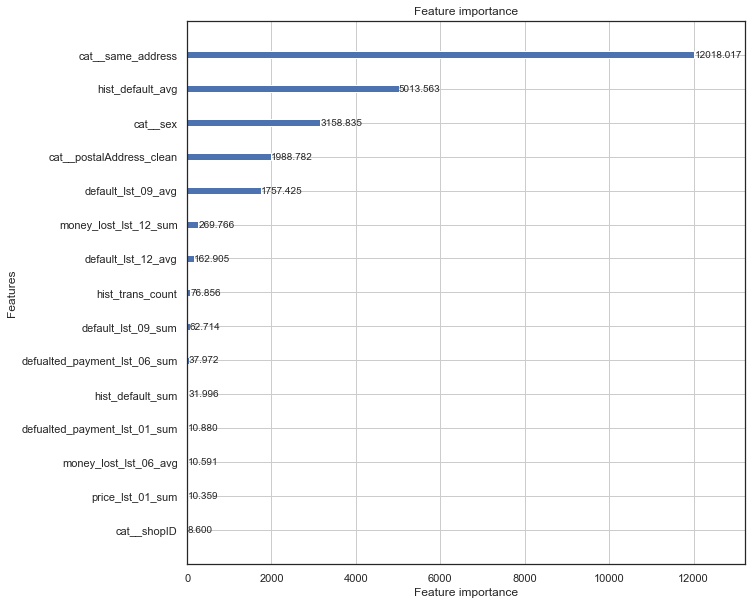

In [346]:
fig, ax2 = plt.subplots(figsize=(10,10))
lgb.plot_importance(model, max_num_features=15, ax=ax2, importance_type = 'gain')